<a href="https://colab.research.google.com/github/gretaangolani/Image-Classification/blob/main/SoccerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries and Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
import zipfile
import cv2
import imghdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline

from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from collections import Counter

# Import libraries for deep learning
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, Rescaling, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, F1Score

In [ ]:
# Unzip the training data
!unzip "drive/MyDrive/SoccerImages/Image_Event_001.zip" -d "drive/MyDrive/SoccerImages"
!unzip "drive/MyDrive/SoccerImages/Image_Event_002.zip" -d "drive/MyDrive/SoccerImages"

In [ ]:
# Unzip the Event data
!unzip "drive/MyDrive/SoccerImages/Image_Event/Event.zip" -d "drive/MyDrive/SoccerImages"

# Unzip the Soccer data
!unzip "drive/MyDrive/SoccerImages/Image_Event/Soccer.zip" -d "drive/MyDrive/SoccerImages"

In [ ]:
def unzip_all_in_folder(folder_path):
    for item in os.listdir(folder_path):
        file_path = os.path.join(folder_path, item)
        if file_path.endswith('.zip'):
            print(f"Unzip {file_path}...")

            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(folder_path)
            print(f"{item} exported in {folder_path}.")

            # Remove zip file
            os.remove(file_path)
            print(f"{file_path} removed.")

train_path = '/content/drive/MyDrive/SoccerImages/Image_Event/Train'
test_path = '/content/drive/MyDrive/SoccerImages/Image_Event/Test'

unzip_all_in_folder(train_path)
unzip_all_in_folder(test_path)

Unzip /content/drive/MyDrive/SoccerImages/Image_Event/Train/To-Subtitue.zip...
To-Subtitue.zip exported in /content/drive/MyDrive/SoccerImages/Image_Event/Train.
/content/drive/MyDrive/SoccerImages/Image_Event/Train/To-Subtitue.zip removed.
Unzip /content/drive/MyDrive/SoccerImages/Image_Event/Train/Right.zip...
Right.zip exported in /content/drive/MyDrive/SoccerImages/Image_Event/Train.
/content/drive/MyDrive/SoccerImages/Image_Event/Train/Right.zip removed.
Unzip /content/drive/MyDrive/SoccerImages/Image_Event/Train/Penalty.zip...
Penalty.zip exported in /content/drive/MyDrive/SoccerImages/Image_Event/Train.
/content/drive/MyDrive/SoccerImages/Image_Event/Train/Penalty.zip removed.
Unzip /content/drive/MyDrive/SoccerImages/Image_Event/Train/Left.zip...
Left.zip exported in /content/drive/MyDrive/SoccerImages/Image_Event/Train.
/content/drive/MyDrive/SoccerImages/Image_Event/Train/Left.zip removed.
Unzip /content/drive/MyDrive/SoccerImages/Image_Event/Train/Free-Kick.zip...
Free-Kick.

In [3]:
!cp -r /content/drive/MyDrive/SoccerImages/General /content/dataset_general  #copy dataset on collab

In [6]:
!cp -r /content/drive/MyDrive/SoccerImages/Image_Event/Train/Split_1 /content/dataset_split_1
!cp -r /content/drive/MyDrive/SoccerImages/Image_Event/Train/Split_2 /content/dataset_split_2 #copy dataset on collab
!cp -r /content/drive/MyDrive/SoccerImages/Image_Event/Train/Split_3 /content/dataset_split_3

In [7]:
!cp -r /content/drive/MyDrive/SoccerImages/Image_Event/Test/Test_1 /content/dataset_test_1
!cp -r /content/drive/MyDrive/SoccerImages/Image_Event/Test/Test_2 /content/dataset_test_2 #copy dataset on collab
!cp -r /content/drive/MyDrive/SoccerImages/Image_Event/Test/Test_3 /content/dataset_test_3

In [8]:
!ls -l /content/dataset_test
!ls -l /content/dataset_train_general
!ls -l /content/dataset_split_1
!ls -l /content/dataset_split_2
!ls -l /content/dataset_split_3

ls: cannot access '/content/dataset_test': No such file or directory
total 100
drwx------ 2 root root 49152 Jan 27 16:04 Event
drwx------ 2 root root 49152 Jan 27 16:04 Soccer
total 968
drwx------ 2 root root 266240 Jan 27 16:11 Center
drwx------ 2 root root 221184 Jan 27 16:09 Left
drwx------ 2 root root 253952 Jan 27 16:13 Other
drwx------ 2 root root 237568 Jan 27 16:06 Right
total 1448
drwx------ 2 root root 229376 Jan 27 16:25  Cards
drwx------ 2 root root 241664 Jan 27 16:22  Corner
drwx------ 2 root root 262144 Jan 27 16:20  Free-Kick
drwx------ 2 root root 241664 Jan 27 16:18  Penalty
drwx------ 2 root root 229376 Jan 27 16:24  Tackle
drwx------ 2 root root 266240 Jan 27 16:16 'To Subtitue'
total 528
drwx------ 2 root root 262144 Jan 27 16:27 Red-Cards
drwx------ 2 root root 270336 Jan 27 16:29 Yellow-Cards


#Data Pre-processing

In [9]:
train_dir_1 = '/content/dataset_split_1'
train_dir_2 = '/content/dataset_split_2'
train_dir_3 = '/content/dataset_split_3'
general_dir = '/content/dataset_general'
test_dir_1 = '/content/dataset_test_1'
test_dir_2 = '/content/dataset_test_2'
test_dir_3 = '/content/dataset_test_3'

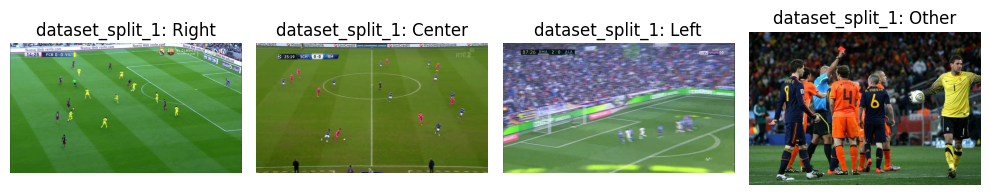

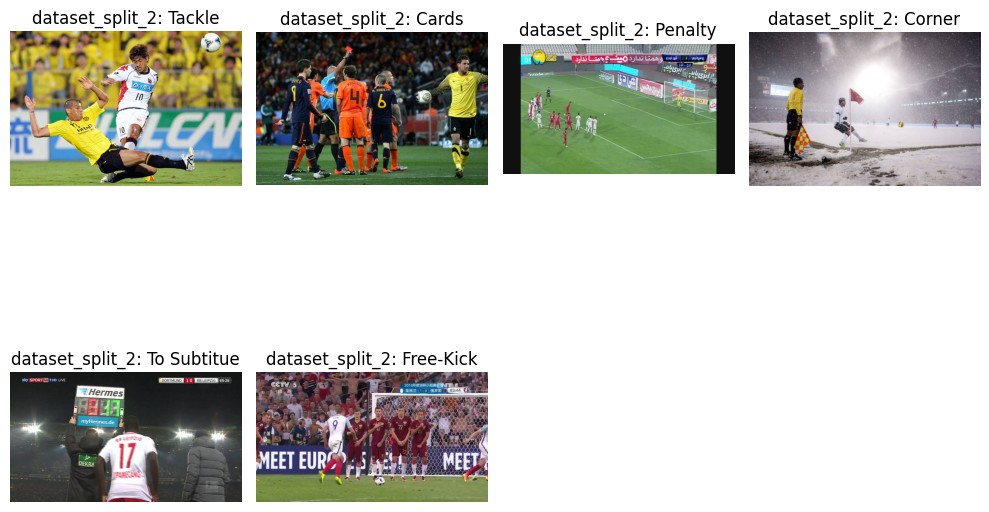

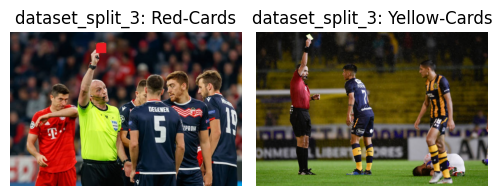

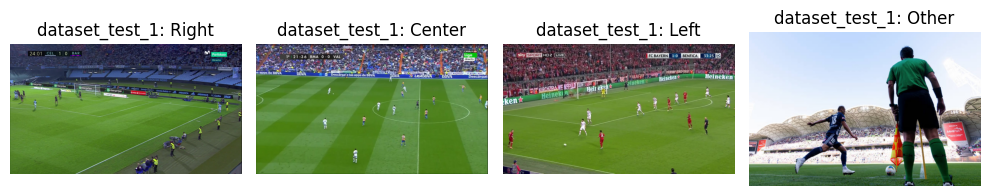

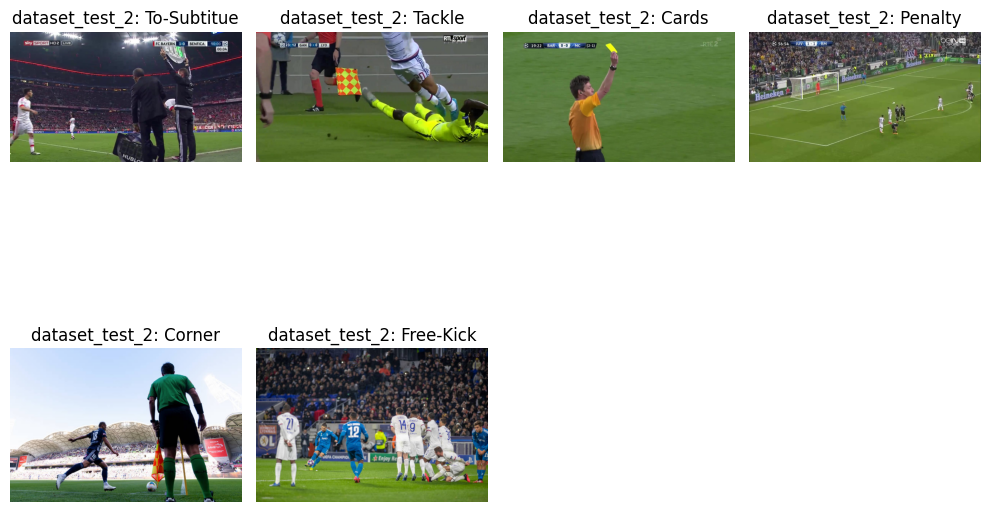

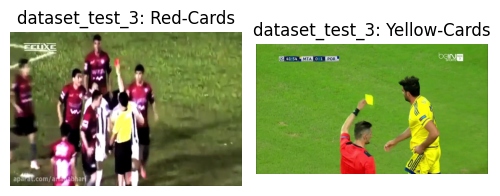

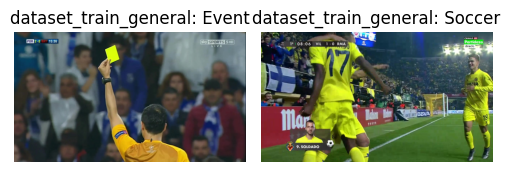

In [28]:
def show_images_from_folders(main_dir):
    subfolders = [f for f in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, f))]

    plt.figure(figsize=(10, 10))
    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(main_dir, subfolder)
        images = [img for img in os.listdir(subfolder_path) if img.lower().endswith(('png', 'jpg', 'jpeg', 'bmp'))]
        if images:
            img = load_img(os.path.join(subfolder_path, images[0]))
            plt.subplot(3, 4, i + 1)
            plt.imshow(img)
            plt.title(f"{os.path.basename(main_dir)}: {subfolder}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images_from_folders(train_dir_1)
show_images_from_folders(train_dir_2)
show_images_from_folders(train_dir_3)
show_images_from_folders(test_dir_1)
show_images_from_folders(test_dir_2)
show_images_from_folders(test_dir_3)
show_images_from_folders(general_dir)

In [12]:
def filter_valid_images(directory):
  class_distributions = []
  for image_class in os.listdir(directory):
    print("Analyzing images in folder {}".format(os.path.join(directory, image_class)))
    count_class_elements = 0
    for image in os.listdir(os.path.join(directory, image_class)):
      image_path = os.path.join(directory, image_class, image)
      try:
        img = load_img(image_path)
        img_array = np.array(img)
        # Check if the image is truncated
        if img_array.nbytes < 75:
          print(f"Truncated image detected: {image_path}")
          os.remove(image_path)
        else:
          count_class_elements += 1
      except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        os.remove(image_path)
        continue
    class_distributions.append({image_class: count_class_elements})
  return class_distributions

In [13]:
general_classes_distribution = filter_valid_images(general_dir)

Analyzing images in folder /content/dataset_train_general/Event
Analyzing images in folder /content/dataset_train_general/Soccer


In [14]:
train_classes_distribution_1 = filter_valid_images(train_dir_1)
train_classes_distribution_2 = filter_valid_images(train_dir_2)
train_classes_distribution_3 = filter_valid_images(train_dir_3)

Analyzing images in folder /content/dataset_split_1/Right
Analyzing images in folder /content/dataset_split_1/Center
Analyzing images in folder /content/dataset_split_1/Left
Analyzing images in folder /content/dataset_split_1/Other
Analyzing images in folder /content/dataset_split_2/Tackle
Analyzing images in folder /content/dataset_split_2/Cards
Analyzing images in folder /content/dataset_split_2/Penalty
Analyzing images in folder /content/dataset_split_2/Corner
Analyzing images in folder /content/dataset_split_2/To Subtitue
Error loading image /content/dataset_split_2/To Subtitue/To Subtitue__22__24.jpg: image file is truncated (75 bytes not processed)
Error loading image /content/dataset_split_2/To Subtitue/To Subtitue__21__14.jpg: cannot identify image file <_io.BytesIO object at 0x7f51143ef8d0>
Analyzing images in folder /content/dataset_split_2/Free-Kick
Analyzing images in folder /content/dataset_split_3/Red-Cards
Analyzing images in folder /content/dataset_split_3/Yellow-Cards


In [15]:
test_classes_distribution_1 = filter_valid_images(test_dir_1)
test_classes_distribution_2 = filter_valid_images(test_dir_2)
test_classes_distribution_3 = filter_valid_images(test_dir_3)

Analyzing images in folder /content/dataset_test_1/Right
Analyzing images in folder /content/dataset_test_1/Center
Analyzing images in folder /content/dataset_test_1/Left
Analyzing images in folder /content/dataset_test_1/Other
Analyzing images in folder /content/dataset_test_2/To-Subtitue
Analyzing images in folder /content/dataset_test_2/Tackle
Analyzing images in folder /content/dataset_test_2/Cards
Analyzing images in folder /content/dataset_test_2/Penalty
Analyzing images in folder /content/dataset_test_2/Corner
Analyzing images in folder /content/dataset_test_2/Free-Kick
Analyzing images in folder /content/dataset_test_3/Red-Cards
Analyzing images in folder /content/dataset_test_3/Yellow-Cards


In [16]:
def make_bar_diagram(labels, values, dataset_type):
    plt.figure(figsize=(10, 4))
    plt.bar(labels, values)
    plt.xlabel('Class')
    plt.ylabel('Values')
    plt.title('Class distribution in {} dataset'.format(dataset_type))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

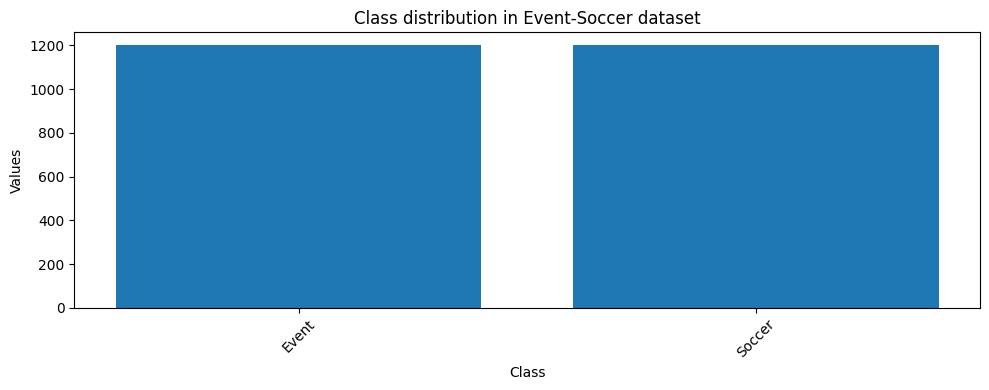

In [17]:
labels = [list(item.keys())[0] for item in general_classes_distribution]
values = [list(item.values())[0] for item in general_classes_distribution]

make_bar_diagram(labels, values, 'Event-Soccer')

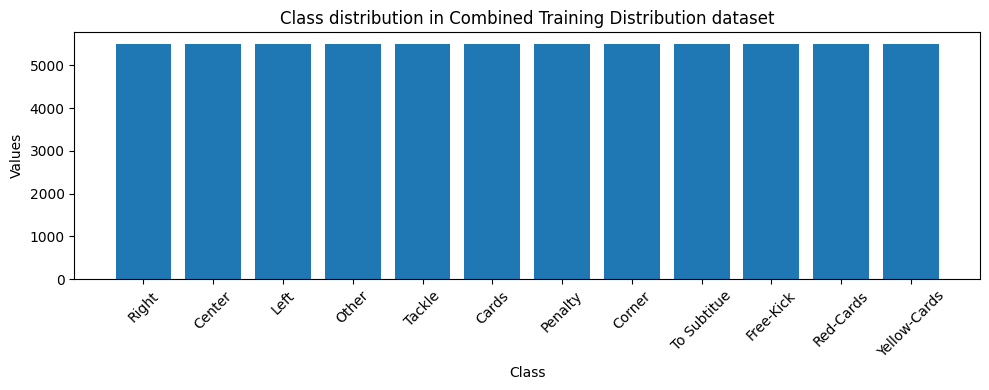

In [18]:
# Combine distributions
combined_distribution = defaultdict(int)

for distribution in [train_classes_distribution_1, train_classes_distribution_2, train_classes_distribution_3]:
    for item in distribution:
        label = list(item.keys())[0]
        value = list(item.values())[0]
        combined_distribution[label] += value

labels = list(combined_distribution.keys())
values = list(combined_distribution.values())

make_bar_diagram(labels, values, 'Combined Training Distribution')

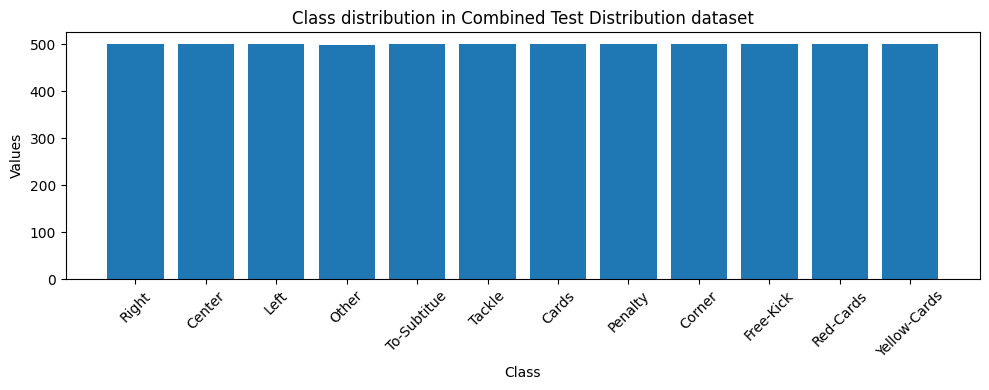

In [19]:
# Combine distributions
combined_distribution = defaultdict(int)
for distribution in [test_classes_distribution_1, test_classes_distribution_2, test_classes_distribution_3]:
    for item in distribution:
        label = list(item.keys())[0]
        value = list(item.values())[0]
        combined_distribution[label] += value

labels = list(combined_distribution.keys())
values = list(combined_distribution.values())

make_bar_diagram(labels, values, 'Combined Test Distribution')

#CNN

In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [6]:
seed_value = 123
tf.random.set_seed(seed_value)

np.random.seed(seed_value)
random.seed(seed_value)

In [24]:
#GENERAL DS
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset_general',
    validation_split=0.4,  # 40% for validation/test
    subset="training",  # 60% train
    seed=seed_value,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# 20% validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset_general',
    validation_split=0.2,
    subset="validation",
    seed=seed_value,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# 20% test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset_general',
    validation_split=0.2,
    subset="validation",
    seed=seed_value,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

train_class_names = train_ds.class_names
test_class_names = test_ds.class_names

print(train_class_names)
print(test_class_names)

Found 2400 files belonging to 2 classes.
Using 1440 files for training.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
Found 2400 files belonging to 2 classes.
Using 480 files for validation.
['Event', 'Soccer']
['Event', 'Soccer']


In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset_split_3',   #split 1, split 2, split 3
  validation_split = 0.2,
  subset = 'training',
  seed=seed_value,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset_split_3',   #split 1, split 2, split 3
  validation_split = 0.2,
  subset = 'validation',
  seed=seed_value,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_class_names = train_ds.class_names
print(train_class_names)

Found 11000 files belonging to 2 classes.
Using 8800 files for training.
Found 11000 files belonging to 2 classes.
Using 2200 files for validation.
['Red-Cards', 'Yellow-Cards']


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset_test_3',  #test 1, test_2, test_3
  seed=seed_value,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_class_names = test_ds.class_names
print(test_class_names)

Found 1000 files belonging to 2 classes.
['Red-Cards', 'Yellow-Cards']


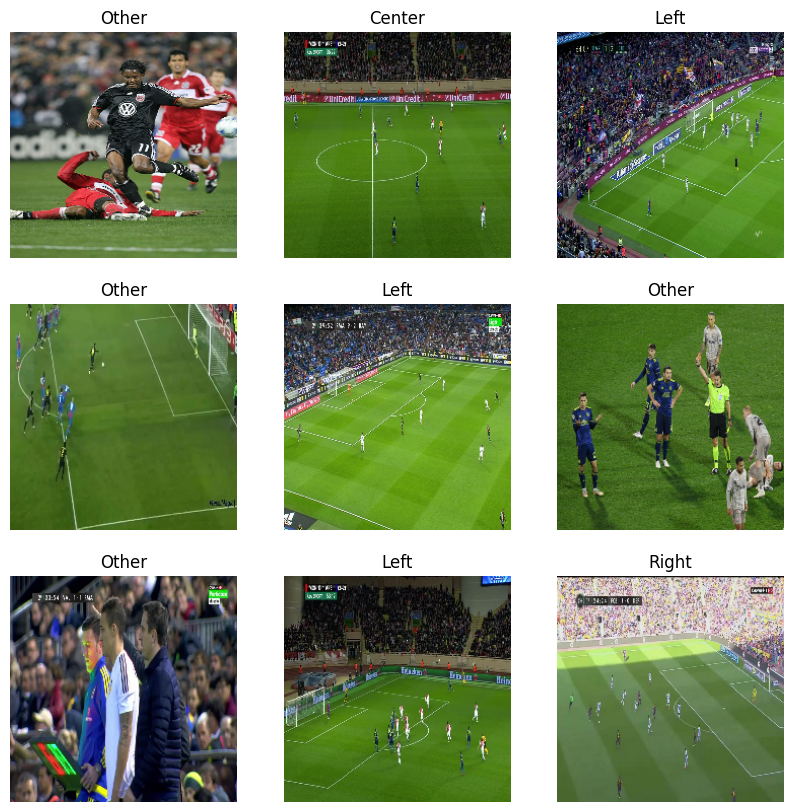

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[labels[i]])
    plt.axis("off")

#MODEL TRAINING

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
def general_classifier():
    model = Sequential([
        layers.InputLayer(input_shape=(img_height, img_width, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Output: "Soccer Image" vs "Event Image"
    ])

    return model

In [ ]:
def no_highlights_classifier():
    model = Sequential([
        layers.InputLayer(input_shape=(img_height, img_width, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.7),
        layers.Dense(len(train_class_names), activation='softmax') #Output: "Center", "Left", "Right", "Other"

     ])

    return model

In [ ]:
def event_classifier():
    model = Sequential([
        layers.InputLayer(input_shape=(img_height, img_width, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.7),
        layers.Dense(len(train_class_names), activation='softmax') #Output: "Corner", "Tackle", "Cards", "Free-kick", "Penalty", "To- Sobstitute"

     ])

    return model

In [ ]:
def card_classifier():
    model = Sequential([
        layers.InputLayer(input_shape=(img_height, img_width, 3)),
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(1, activation='sigmoid')  # Output: "Red Card" vs "Yellow Card"
    ])

    return model

In [ ]:
model = event_classifier() #fill with the correct model: general_classifier(), no_highlights_classifier(),event_classifier(), card_classifier()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # or
    #loss= 'binary_crossentropy', #for binary classification
    metrics=['accuracy']
)


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_20 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_18 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,182 (98.37 MB)

 Trainable params: 25,785,670 (98.36 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/20
191/825 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - accuracy: 0.4179 - loss: 5.3573

In [ ]:
#Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Prediction on the test set

In [11]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

true_labels = []
predicted_labels = []
predicted_scores = []

In [13]:
#CODE FOR BINARY PREDICTION (I.E. DISTINCTION BETWEEN SOCCER-EVENT AND YELLOW- RED CARDS)
test_data_iterator = test_ds.as_numpy_iterator()
for batch in test_data_iterator:
  X, y = batch
  yhat = model.predict(X)
  # Convert model output to binary predictions (0 or 1)
  predicted_classes = (yhat > 0.5).astype(int)

  # Update metrics using binary predictions and original sparse labels (y)
  precision.update_state(y, predicted_classes)
  recall.update_state(y, predicted_classes)
  accuracy.update_state(y, predicted_classes)


  # Append true and predicted labels to the lists
  true_labels.extend(y)  # Use original sparse labels (y)
  predicted_labels.extend(predicted_classes.flatten())  # Flatten predictions

  predicted_scores.extend(yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

In [10]:
#CODE FOR MULTIPLE CLASS PREDICTION (I.E. OTHER MODELS)
test_data_iterator = test_ds.as_numpy_iterator()
for batch in test_data_iterator:
  X, y = batch
  yhat = model.predict(X)

  # Convert sparse labels to one-hot encoding
  y_one_hot = tf.keras.utils.to_categorical(y, num_classes=len(test_class_names))

  precision.update_state(y_one_hot, yhat)  # Use one-hot encoded labels
  recall.update_state(y_one_hot, yhat)     # Use one-hot encoded labels
  accuracy.update_state(y_one_hot, yhat)    # Use one-hot encoded labels

  # Convert one-hot encoded predictions to class labels
  predicted_classes = np.argmax(yhat, axis=1)
  true_classes = y # y is already containing the true class indices

  # Append true and predicted labels to the lists
  true_labels.extend(true_classes)
  predicted_labels.extend(predicted_classes)

  predicted_scores.extend(yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7852 - loss: 0.5087
Test Loss: 0.5010965466499329
Test Accuracy: 0.7910000085830688


In [19]:
print(classification_report(true_labels, predicted_labels, target_names= test_class_names))

              precision    recall  f1-score   support

   Red-Cards       0.95      0.61      0.75       500
Yellow-Cards       0.71      0.97      0.82       500

    accuracy                           0.79      1000
   macro avg       0.83      0.79      0.78      1000
weighted avg       0.83      0.79      0.78      1000



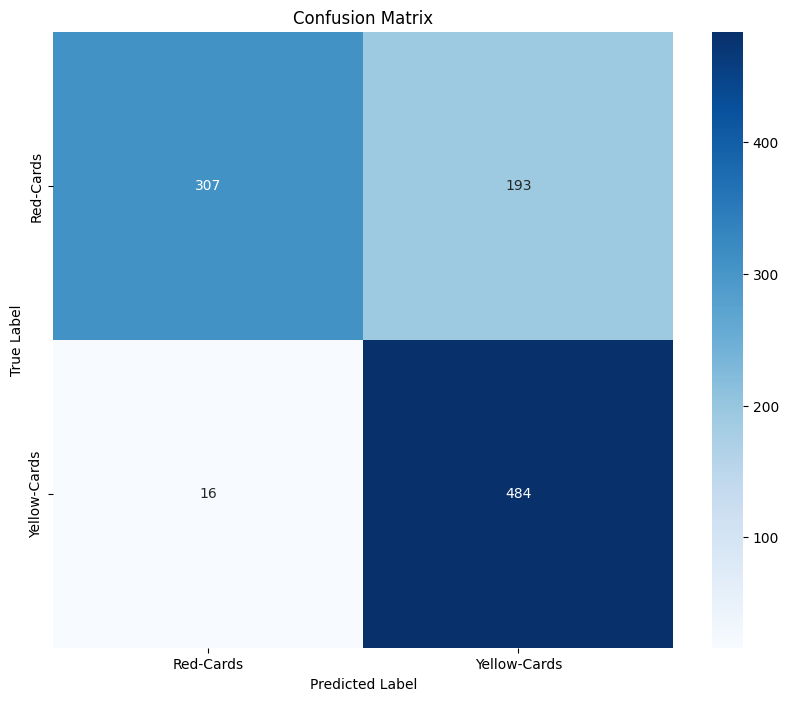

In [20]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/SoccerImages/Model/split2_augumentation.keras') #SAVING THE MODEL

#Deeper Analysis

In [11]:
# Load saved models
model_general = tf.keras.models.load_model('/content/drive/MyDrive/SoccerImages/Model/split0.keras')
model_event = tf.keras.models.load_model('/content/drive/MyDrive/SoccerImages/Model/split1_1.keras')
model_specific_event = tf.keras.models.load_model('/content/drive/MyDrive/SoccerImages/Model/split2.keras')
model_cards = tf.keras.models.load_model('/content/drive/MyDrive/SoccerImages/Model/split3_1.keras')


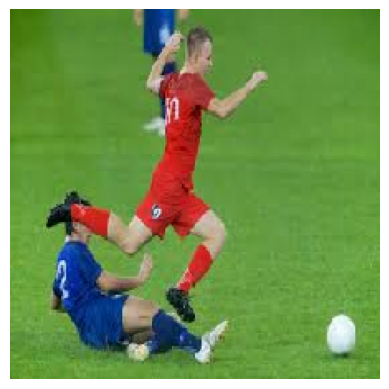

In [6]:
image_path = "/content/drive/MyDrive/SoccerImages/images/tackle.jpeg"

# Load images
image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
image_array = tf.keras.utils.img_to_array(image)
image_array = tf.expand_dims(image, 0)

# Plot image
plt.imshow(image_array[0])
plt.axis("off")
plt.show()

Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Result: {'Model': 'Model_3_Specific_Event', 'Predicted_Class': 'Tackle'}


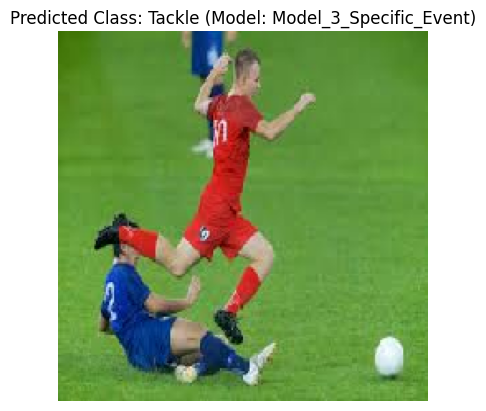

In [7]:
# Classes dictionaries
class_names_model_1 = {0: 'Event', 1: 'Soccer'}
class_names_model_2 = {0: 'Center', 1: 'Left', 2: 'Other', 3: 'Right'}
class_names_model_3 = {0: 'Cards', 1: 'Corner', 2: 'Free-Kick', 3: 'Penalty', 4: 'Tackle', 5: 'To substitute'}
class_names_model_4 = {0: 'Red-Cards', 1: 'Yellow-Cards'}


def classify_single_image(image_array):
    """
    Classifica un'immagine in base a una serie di modelli sequenziali.
    """

    print("Image shape:", image_array.shape)

    # Model 1: Classify in Event - Not Event
    prediction_1 = model_general.predict(image_array)
    # Convert prediction to an integer (0 or 1)
    is_event = int(prediction_1[0][0] > 0.5)

    if is_event == 0:  # If classification returns Event
        # Proceed to Model 2
        prediction_2 = model_event.predict(image_array)
        predicted_class_2 = tf.argmax(prediction_2[0]).numpy()

        if predicted_class_2 == 2:  # If classification returns Other
            # Proceed to Model 3
            prediction_3 = model_specific_event.predict(image_array)
            predicted_class_3 = tf.argmax(prediction_3[0]).numpy()


            if predicted_class_3 == 0:  # If classification returns Cards
                #Proceed to Model 4
                prediction_4 = model_cards.predict(image_array)
                predicted_class_4 = int(prediction_4[0][0] > 0.5)

                return {
                    "Model": "Model_4_Cards",
                    "Predicted_Class": class_names_model_4.get(predicted_class_4, "Unknown")
                }
            else:
                return {
                    "Model": "Model_3_Specific_Event",
                    "Predicted_Class": class_names_model_3.get(predicted_class_3, "Unknown")
                }
        else:
            return {
                "Model": "Model_2_Highlights_NoHighlights",
                "Predicted_Class": class_names_model_2.get(predicted_class_2, "Unknown")
            }
    else:
        return {
            "Model": "Model_1_Soccer_Event",
            "Predicted_Class": class_names_model_1.get(is_event, "Unknown")
        }



result = classify_single_image(image_array)

# plot results
print("Result:", result)
plt.imshow(image_array[0])
plt.title(f"Predicted Class: {result['Predicted_Class']} (Model: {result['Model']})")
plt.axis("off")
plt.show()